In [304]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [333]:
# sensor and ground truth data 
gyro = pd.read_csv("ZurichMAVData/RawGyro.csv")
accel = pd.read_csv("ZurichMAVData/RawAccel.csv")
baro = pd.read_csv("ZurichMAVData/BarometricPressure.csv")
gps = pd.read_csv("ZurichMAVData/OnboardGPS.csv")
truth = pd.read_csv("ZurichMAVData/OnboardPose.csv")

# data cleaning

gps = gps.drop(['Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17'], axis=1)
# these columns were either empty or were all NaN's

%store -r gps_vel_noise_cov
%store -r gps_pos_noise_cov
%store -r accel_noise_cov 
%store -r gyro_noise_cov
%store -r baro_noise_var
%store -r baro_bias
%store -r accel_bias
%store -r gyro_bias

In [419]:
"""
Conventions: 
- Angular velocities must have radians per second unit, 
accelerations must have meters per second squared unit. 
- ENU: East-North-UP is the coordinate system we've chosen
"""

def quat_to_rot(q):
    """
    input: normalized np.array
    q = w + xi+ yj+ zk or q = [w,x,y,z]
    Quaternion [w,x,y,z] to rotation matrix: 
    https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/
    Example: 
    a_body: body frame acceleration  
    a_earth: earth frame acceleration
    a_earth = R a_body
    https://automaticaddison.com/how-to-describe-the-rotation-of-a-robot-in-3d/
    """
    w, x, y, z = q
    R = np.array([
        [1-2*(y**2+z**2), 2*(x*y-z*w),     2*(x*z+y*w)],
        [2*(x*y+z*w),     1-2*(x**2+z**2), 2*(y*z-x*w)],
        [2*(x*z-y*w),     2*(y*z+x*w),     1-2*(x**2+y**2)]
    ])
    return R

def normalize_quat(q):
    """
    q is an np.array
    q^2 = w^2 + x^2 + y^2 + z^2
    """
    return q / np.linalg.norm(q)

def quat_derivative(q, omega):
    """
    omega:              (3x1) angular velocity vector
    q:                  (4x1) quaternion vector
    q derivative:       q_dot = 0.5 * omega_operator * q
    omega_operator:     https://ahrs.readthedocs.io/en/latest/filters/angular.html#id12                   
    """
    w_x, w_y, w_z = omega
    w, x, y, z = q
    q_dot = 0.5 * np.array([
        -x*w_x - y*w_y - z*w_z,
         w*w_x + y*w_z - z*w_y,
         w*w_y - x*w_z + z*w_x,
         w*w_z + x*w_y - y*w_x
    ])
    return q_dot


In [413]:
# Extended Kalman Filter class
# we use the precomputed the biases


class SimpleEKF:

    def __init__(self):
        # 17 state variables 
        # state = [q_w, q_x, q_y, q_z, p_x, p_y, p_z, v_x, v_y, v_z, b_g_x, b_g_y, b_g_z, b_a_x, 
        #         b_a_y, b_a_z, b_b_z]
        self.q          = np.array([1, 0, 0, 0], dtype=float)   # quaternion
        self.p          = np.zeros(3)                           # position ENU
        self.v          = np.zeros(3)                           # velocity ENU
        self.bias_gyro  = gyro_bias                             # gyro bias
        self.bias_accel = accel_bias                            # accel bias
        self.bias_baro  = baro_bias                             # barometer bias

        # State covariance
        self.P = np.eye(17) * 0.1   # simplified assumption

        # Process noise 
        self.Q = np.eye(17) * 1e-3  # simplified assumption
 
        
        self.g = np.array([0, 0, -9.81])

    def propagate(self, acc_data, gyro_data, dt):
        """
        Propagate state with IMU (no magnetometer) measurements
        dt: stepsize in seconds
        """

        # Bias adjusted
        omega = gyro_data - self.bias_gyro
        acc = acc_data - self.bias_accel

        # Update quaternion: https://ahrs.readthedocs.io/en/latest/filters/angular.html#id12
        # new_q = old_q + q_dot * dt
        dq = quat_derivative(self.q, omega) * dt
        self.q = normalize_quat(self.q + dq)

        # Rotate acceleration from body to earth frame
        # generate rotation matrix from updated quaternions
        R = quat_to_rot(self.q)
        acc_nav = R @ acc + self.g

        # Update (simplified) velocity & position
        self.v += acc_nav * dt
        self.p += self.v * dt

        # Covariance prediction (simplified: just inflate with Q)
        self.P += self.Q * dt

    def gps_update(self, GPS_pos_data, GPS_pos_covar):
        """
        GPS position update
        Input:      
        GPS_pos_data:       (3x1) GPS reported position in ENU
        GPS_covar_matrix:   (3x3) GPS position uncertainty covariance matrix
        """
        # Current GPS estimate
        z = GPS_pos_data

        # Current position estimate
        h = self.p

        # Compute the residual 
        y = z - h          

        # Construct the measurement jacobian, H        
        """
        measurement function, h(x) = [x4, x5, x6] where x: state vector 
        /partial xi/ partial xj = 1 when i=j,0 otherwise
        """
        H = np.zeros((3, 17)) 
        H[:, 4:7] = np.eye(3)  

        # innovation covariance = prediction covariance + measurement covariance
        S = H @ self.P @ H.T + GPS_pos_covar

        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)

        # Kalman adjusted state
        dx = K @ y

        # Kalman adjusted state covariance
        self.P = (np.eye(17) - K @ H) @ self.P

        # Apply correction to position
        self.p += dx[4:7]

    def gps_vel_update(self, GPS_vel_data, GPS_vel_covar):
        """
        GPS velocity update
        """
        z           = GPS_vel_data
        h           = self.v
        y           = z - h
        H           = np.zeros((3, 17))
        H[:, 7:10]   = np.eye(3)  # dv/dx
        S           = H @ self.P @ H.T + GPS_vel_covar
        K           = self.P @ H.T @ np.linalg.inv(S)
        dx          = K @ y
        self.P      = (np.eye(17) - K @ H) @ self.P
        self.v      += dx[7:10]

    def baro_update(self, alt_data, baro_covar):
        """
        Barometer altitude update
        Updates both barometer bias and altitude 
        alt_data: (3x1) numpy array [0,0,z]
        """
        z               = alt_data[2]
        h               = self.p[2] + self.bias_baro[2]
        y               = z - h
        H               = np.zeros((1, 17))
        H[0, 6]         = 1.0                           # dz/dp
        H[0, -1]        = 1.0                           # dz/db_bar
        S               = H @ self.P @ H.T + baro_covar
        K               = 1/S*(self.P @ H.T)
        dx              = K * y
        self.P          = (np.eye(17) - K @ H) @ self.P
        self.p[2]       += dx[5]
        self.bias_baro  += dx[-1]


Data has been cleaned and all the minimum reqs were met except for the state covariance matrix and noise covariance. For now, I will skip the state and noise covariance. I need to align the timestamps of the IMU and GPS so that the algorithm can run. The problem we'll need to address is that GPS has a higher frequency than the IMU. 

In [414]:
# prep GPS Data

## convert ECEF (Earth centered, Earth fixed) to ENU (East, North, Up)

### following readme.txt: transform from 1e7 degrees to degrees

gps_lat = gps[' lat'].to_numpy() / 1e7
gps_lon = gps[' lon'].to_numpy() / 1e7
gps_alt = gps[' alt'].to_numpy() / 1000  # mm to m


R = 6371000 # Earth's radius in meters
init_lat = gps_lat[0]
init_lon = gps_lon[0]
init_alt = gps_alt[0]

### simplified ECEF to ENU conversion

gps_x_coord = (gps_lon - init_lon) * np.cos(np.deg2rad(init_lat)) * (np.pi/180) * R
gps_y_coord = (gps_lat - init_lat) * (np.pi/180) * R
gps_z_coord = (gps_alt - init_alt)


gps_pos_data = np.stack((gps_x_coord, gps_y_coord, gps_z_coord), axis=1)



In [415]:
gyro_data    = gyro[[" x", " y", " z"]].to_numpy()
accel_data   = accel[[" x", " y", " z"]].to_numpy()
z_coord     = baro[" Altitude"].to_numpy()
baro_data    = np.column_stack((np.zeros_like(z_coord), np.zeros_like(z_coord), z_coord))
gps_vel_data = gps[[" vel_e_m_s", " vel_n_m_s", " vel_d_m_s"]].to_numpy() # East-North-Up coordinates


#  to synchronize timestamps from IMU + GPS, we'll use zero order hold
## we create a list of events

ekf = SimpleEKF()

events = []

## create seperate arrays of timestamps for each sensor

gyro_ts = gyro['Timpstemp']
accel_ts = accel['Timpstemp']
gps_ts = gps['Timpstemp']
baro_ts = baro['Timpstemp']

## populate events

events += [(t, "accel", i) for i, t in enumerate(accel_ts)]
events += [(t, "gyro", i) for i, t in enumerate(gyro_ts)]
events += [(t, "gps", i) for i, t in enumerate(gps_ts)]
events += [(t, "baro", i) for i, t in enumerate(baro_ts)]
events.sort(key=lambda x: x[0])

## create a helper function to return the index 
### bisect.bisect_right, given sorted timestamp array and t, returns the index where to put t
import bisect
def closest_index_before(ts_array, t): # assumes that ts_array is sorted
    i = bisect.bisect_right(ts_array, t) - 1 # either returns the index for ts t or closest ts to t
    if i < 0:
        return None
    return i

last_time = events[0][0]  # starting timestamp
last_accel_idx = closest_index_before(accel_ts, last_time)
last_gyro_idx = closest_index_before(gyro_ts, last_time)

pos_estimate_ekf = []

for event_time, sensor, idx in events:
    # 1) Propagate from last_time -> t_event using accel+gyro input
    dt = (event_time - last_time)/(10**6) # express in seconds
    if dt < 0:
        continue  # out-of-order, skip 
    if dt > 0:
        # find the best IMU input to use for propagation during [last_time, t_event]
        # Option A: use last known imu samples
        if last_accel_idx is not None and last_gyro_idx is not None:
            accel_meas = accel_data[last_accel_idx]
            gyro_meas  = gyro_data[last_gyro_idx]
            # propagate with dt (can be > imu sample interval)
            ekf.propagate(accel_meas, gyro_meas, dt)
        else:
            # before IMU starts 
            ekf.propagate(np.zeros(3), np.zeros(3), dt)
            # the other solution is to set the init_pos with GPS initial coords
    """
    dt = 0 may happen if measurements for diff sensor were taken at the same time
    """

    # 2) Now apply the measurement that occurs at t_event
    if sensor == "gps":
        pos_meas = gps_pos_data[idx]   # in ENU meters
        vel_meas = gps_vel_data[idx]
        R_pos    = gps_pos_noise_cov   
        R_vel    = gps_vel_noise_cov
        ekf.gps_update(pos_meas, R_pos)
        ekf.gps_vel_update(vel_meas, R_vel)
    elif sensor == "baro":
        alt_meas = baro_data[idx]
        ekf.baro_update(alt_meas,  0.14959922)
    elif sensor == "gyro" or sensor == "accel":
        
        last_gyro_idx  = idx
        last_accel_idx = idx

    pos_estimate_ekf.append(np.copy(ekf.p))
    
    

/var/folders/8f/hdn24gtx1j3ctgv558drb7r00000gn/T/ipykernel_98512/3689174100.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.p[2]       += dx[5]


In [416]:
y_coords = np.array(pos_estimate_ekf)[:,1]
x_coords = np.array(pos_estimate_ekf)[:,0]

In [417]:
len(y_coords), len(events)

(162321, 162321)

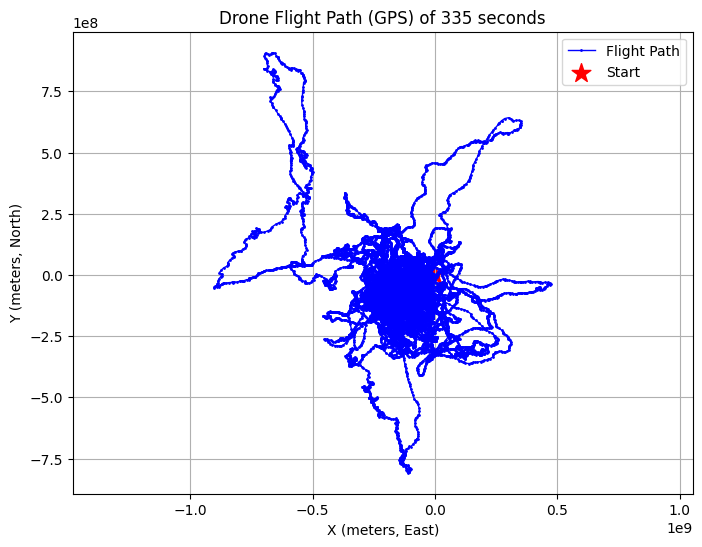

In [418]:
plt.figure(figsize=(8,6))
plt.plot(
    x_coords[0:50000], y_coords[0:50000],
    marker='o',       # circle marker
    markersize=1,     # make marker smaller
    linestyle='-',    # solid line
    linewidth=1,      # make line thinner
    color='b',
    label='Flight Path'
)
plt.scatter(x_coords[0], y_coords[0], s=200, color='red', marker='*', label='Start')
plt.xlabel("X (meters, East)")
plt.ylabel("Y (meters, North)")
# 7009129, 341701724 microseconds
plt.title("Drone Flight Path (GPS) of 335 seconds")
plt.legend()
plt.axis('equal')  # equal aspect ratio so trajectory isn’t distorted
plt.grid(True)
plt.show()